# Dimensionality Reduction with Iris Dataset

**Step 1:** Load data:

In [237]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.lda import LDA
from scipy.cluster.vq import kmeans
from scipy.spatial.distance import euclidean


df = pd.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None, sep=',')

df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']
df.dropna(how="all", inplace=True)

X = df.ix[:,0:4].values
y = df.ix[:,4].values

class_list = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [238]:
df.head()

,sepal_len,sepal_wid,petal_len,petal_wid,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


**Step 2:** Perform PCA on the Iris dataset:

In [239]:
X_std = StandardScaler().fit_transform(X)

cov_mat = np.cov(X_std.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

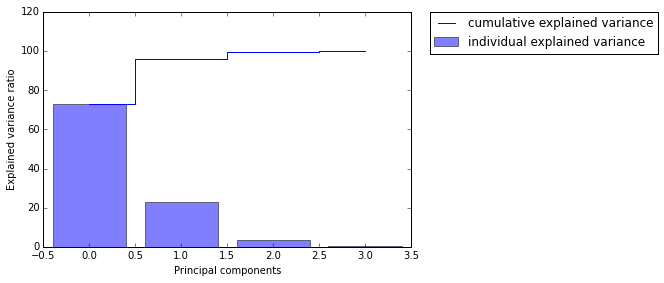

In [240]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(4), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
plt.step(range(4), cum_var_exp, where='mid',
             label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()

In [241]:
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X_std)

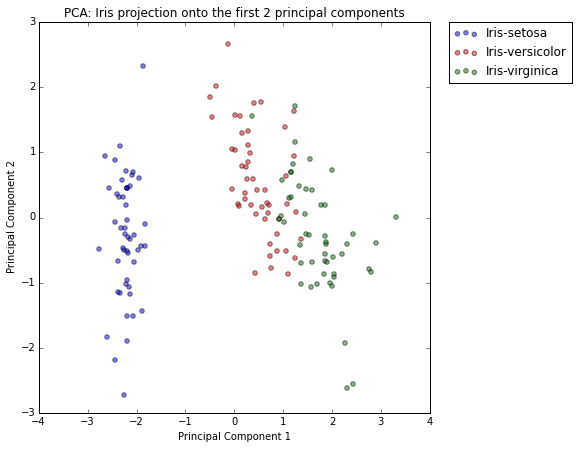

In [242]:
plt.figure(figsize=(7,7))
for lab, col in zip(class_list,('blue','red','green')):
    plt.scatter(Y_sklearn[y==lab, 0], Y_sklearn[y==lab, 1], label=lab, c=col, alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('PCA: Iris projection onto the first 2 principal components')

**Step 3:** Perform k-Means algorithm on the PCA decomposed dataset, and compare the performance on the decomposed dataset to the performance on the raw dataset:

In [243]:
df_pca = pd.DataFrame(Y_sklearn, columns=['PC1','PC2'])
df_pca['class'] = df.ix[:,4].values
df_pca.head()

,PC1,PC2,class
0,-2.264542,-0.505704,Iris-setosa
1,-2.086426,0.655405,Iris-setosa
2,-2.367950,0.318477,Iris-setosa
3,-2.304197,0.575368,Iris-setosa
4,-2.388777,-0.674767,Iris-setosa


In [244]:
KM = kmeans(df_pca[['PC1','PC2']].values,3)

In [245]:
def distances(series):
    for i in range(3):
        series[i]=euclidean(series.loc[['PC1','PC2']],KM[0][i])
    return series

df_pca = pd.concat([df_pca,pd.DataFrame(columns=list('012'))])
df_pca = df_pca.apply(distances, axis=1)
df_pca['cluster'] = df_pca[[0,1,2]].idxmin(axis=1).astype(int)
df_pca.head()

,0,1,2,PC1,PC2,class,cluster
0,4.035638,0.218037,3.160944,-2.264542,-0.505704,Iris-setosa,1
1,4.082350,0.957024,2.722805,-2.086426,0.655405,Iris-setosa,1
2,4.256656,0.628323,3.033953,-2.367950,0.318477,Iris-setosa,1
3,4.264007,0.871650,2.944212,-2.304197,0.575368,Iris-setosa,1
4,4.155557,0.418042,3.343926,-2.388777,-0.674767,Iris-setosa,1


In [246]:
KM2 = kmeans(df[['sepal_len','sepal_wid','petal_len','petal_wid']].values,3)

In [247]:
def distances(series):
    for i in range(3):
        series[i]=euclidean(series.loc[['sepal_len','sepal_wid','petal_len','petal_wid']],KM2[0][i])
    return series

df = pd.concat([df, pd.DataFrame(columns=list('012'))])
df = df.apply(distances, axis=1)
df['cluster'] = df[[0,1,2]].idxmin(axis=1).astype(int)
df.head()

,0,1,2,class,petal_len,petal_wid,sepal_len,sepal_wid,cluster
0,5.031328,3.412511,0.146942,Iris-setosa,1.4,0.2,5.1,3.5,2
1,5.087506,3.389640,0.438169,Iris-setosa,1.4,0.2,4.9,3.0,2
2,5.252292,3.560114,0.412301,Iris-setosa,1.3,0.2,4.7,3.2,2
3,5.127043,3.412319,0.518837,Iris-setosa,1.5,0.2,4.6,3.1,2
4,5.076381,3.460312,0.197970,Iris-setosa,1.4,0.2,5.0,3.6,2


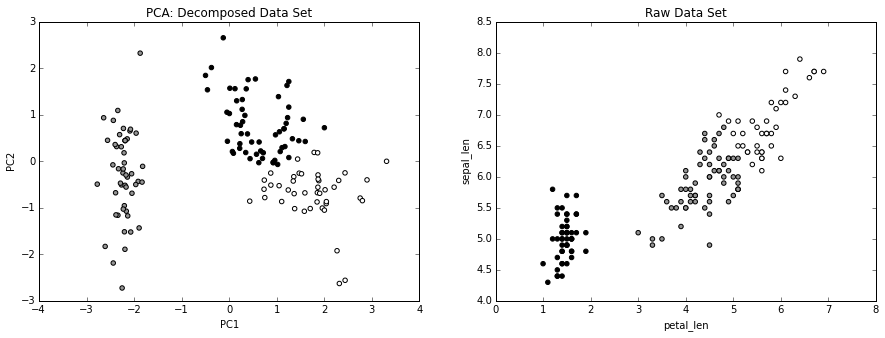

In [248]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

df_pca.plot(kind='scatter',x='PC1',y='PC2',c='cluster',ax=axs[0],colorbar=False,
            title='PCA: Decomposed Data Set')

df.plot(kind='scatter',x='petal_len',y='sepal_len',c='cluster',ax=axs[1],colorbar=False,
        title='Raw Data Set')

k-Means on the raw dataset performs slightly better than that of the decomposed dataset:

In [249]:
df_check = pd.DataFrame(pd.pivot_table(df,index='class',columns='cluster',aggfunc=len))['0']
df_check

cluster,0,1,2
class,,,
Iris-setosa,NaN,NaN,50
Iris-versicolor,3,47,NaN
Iris-virginica,36,14,NaN


In [250]:
df_pca_check = pd.DataFrame(pd.pivot_table(df_pca,index='class',columns='cluster',aggfunc=len))['0']
df_pca_check

cluster,0,1,2
class,,,
Iris-setosa,NaN,50,NaN
Iris-versicolor,10,NaN,40
Iris-virginica,33,NaN,17


**Step 4:** Perform LDA on the Iris dataset:

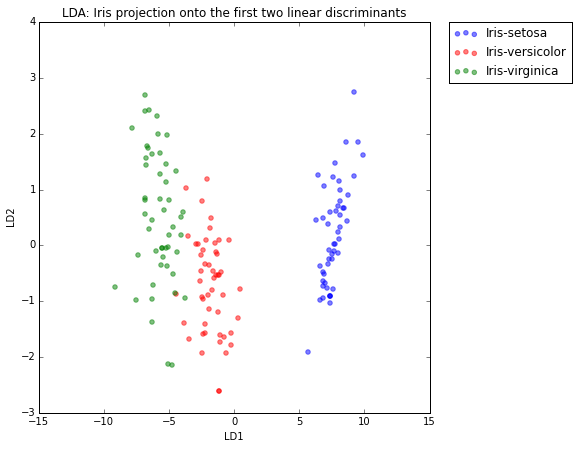

In [251]:
sklearn_lda = LDA(n_components=2)
X_lda_sklearn = sklearn_lda.fit_transform(X,y)

plt.figure(figsize=(7,7))
for label, marker, color in zip(
    class_list,('o','o','o'),('blue','red','green')):
    plt.scatter(x=X_lda_sklearn[:,0][y==label],y=X_lda_sklearn[:,1][y==label],
                marker=marker,color=color,alpha=0.5,label=label)
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('LDA: Iris projection onto the first two linear discriminants')

**Step 5:** Perform k-Means algorithm on the LDA decomposed dataset, and compare the performance on the decomposed dataset to the performance on the raw dataset:

In [252]:
df_lda = pd.DataFrame(X_lda_sklearn, columns=['LD1','LD2'])
df_lda['class'] = df.ix[:,3].values
df_lda.head()

,LD1,LD2,class
0,8.084953,0.328454,Iris-setosa
1,7.147163,-0.755473,Iris-setosa
2,7.511378,-0.238078,Iris-setosa
3,6.837676,-0.642885,Iris-setosa
4,8.157814,0.540639,Iris-setosa


In [253]:
KM3 = kmeans(df_lda[['LD1','LD2']].values,3)

def distances(series):
    for i in range(3):
        series[i]=euclidean(series.loc[['LD1','LD2']],KM3[0][i])
    return series

df_lda = pd.concat([df_lda,pd.DataFrame(columns=list('012'))])
df_lda = df_lda.apply(distances, axis=1)
df_lda['cluster'] = df_lda[[0,1,2]].idxmin(axis=1).astype(int)
df_lda.head()

,0,1,2,LD1,LD2,class,cluster
0,13.852173,0.483428,9.914066,8.084953,0.328454,Iris-setosa,1
1,12.975629,1.075464,8.916911,7.147163,-0.755473,Iris-setosa,1
2,13.298760,0.462582,9.295502,7.511378,-0.238078,Iris-setosa,1
3,12.656857,1.156309,8.608152,6.837676,-0.642885,Iris-setosa,1
4,13.923773,0.633710,10.011733,8.157814,0.540639,Iris-setosa,1


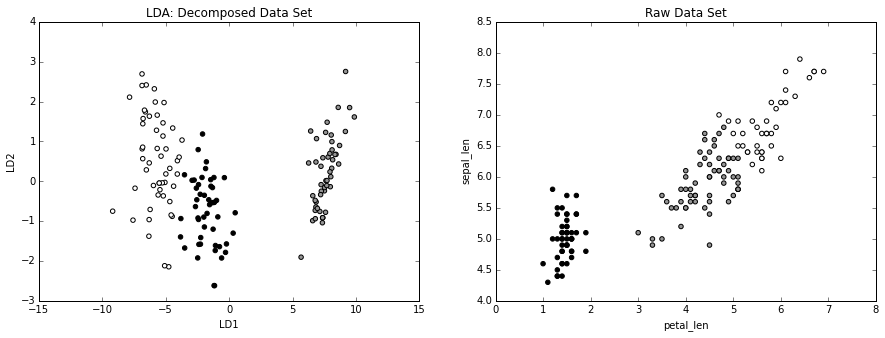

In [254]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

df_lda.plot(kind='scatter',x='LD1',y='LD2',c='cluster',ax=axs[0],colorbar=False,
            title='LDA: Decomposed Data Set')

df.plot(kind='scatter',x='petal_len',y='sepal_len',c='cluster',ax=axs[1],colorbar=False,
        title='Raw Data Set')

k-Means on the LDA decomposed dataset performs better than that of the raw dataset:

In [255]:
df_check = pd.DataFrame(pd.pivot_table(df,index='class',columns='cluster',aggfunc=len))['0']
df_check

cluster,0,1,2
class,,,
Iris-setosa,NaN,NaN,50
Iris-versicolor,3,47,NaN
Iris-virginica,36,14,NaN


In [256]:
df_lda_check = pd.DataFrame(pd.pivot_table(df_lda,index='class',columns='cluster',aggfunc=len))['0']
df_lda_check

cluster,0,1,2
class,,,
Iris-setosa,NaN,50,NaN
Iris-versicolor,2,NaN,48
Iris-virginica,49,NaN,1
